In [1]:
# import mss # Can use mss for screen cap
import pyautogui
import time
import Quartz
# import cv2
import numpy as np
# import pytesseract
from matplotlib import pyplot as plt
import gymnasium as gym
from gymnasium import envs
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import launch_ruffle
import enter_game
import multiprocessing
import subprocess
from selenium import webdriver
from selenium.webdriver.safari.options import Options
from PIL import Image
import mss
import cv2
import traceback
import enter_game

In [2]:
# Configuration
PORT = 8000
GAME_URL = f"http://localhost:{PORT}/launch_ruffle.html"
SAFARI_WEBDRIVER_URL = "http://localhost:4444"

In [3]:
# Environment setup functions
def start_ruffle_host():
    """
    Starts the HTTP server for hosting the Ruffle game and returns the process.
    """
    print("Starting the Ruffle host server...")
    server_process = subprocess.Popen(["python", "-m", "http.server", str(PORT)], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    time.sleep(3)
    print("Ruffle host server started.")
    return server_process

def start_safari_webdriver():
    """
    Starts Safari WebDriver and opens the game URL, returning the process and WebDriver.
    """
    print("Starting Safari WebDriver...")
    safari_process = subprocess.Popen(["safaridriver", "-p", "4444"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    time.sleep(3)
    print("Safari WebDriver started.")

    safari_options = Options()
    safari_options.set_capability("browserName", "safari")
    driver = webdriver.Remote(command_executor=SAFARI_WEBDRIVER_URL, options=safari_options)
    print("Opening the game URL...")
    driver.get(GAME_URL)
    time.sleep(5)
    return safari_process, driver

# Game setup and automation functions
def run_enter_game():
    """
    Automates the initial game entry actions, such as navigating past menus or starting the game.
    """
    time.sleep(5)
    safari_window = enter_game.get_most_recent_window_by_owner("Safari")
    if safari_window:
        enter_game.enter_game(safari_window)
    else:
        print("No Safari window found.")

# Observation and canvas functions
def fetch_canvas_position_and_size(driver):
    """
    Fetches the canvas size and position for targeted screen capture within the game area.
    """
    try:
        print("Attempting to access canvas through JavaScript...")
        canvas_info = driver.execute_script('''
            let rufflePlayer = document.querySelector('ruffle-player');
            if (rufflePlayer && rufflePlayer.shadowRoot) {
                let shadowRoot = rufflePlayer.shadowRoot;
                let canvas = shadowRoot.querySelector('canvas');
                if (canvas) {
                    let rect = canvas.getBoundingClientRect();
                    return {left: rect.left, top: rect.top, width: rect.width, height: rect.height};
                }
            }
            return null;
        ''')
        if canvas_info:
            print(f"Canvas Position and Size: Left = {canvas_info['left']}, Top = {canvas_info['top']}, Width = {canvas_info['width']}, Height = {canvas_info['height']}")
            return canvas_info
        else:
            print("Canvas element or window position was not found.")
            return None
    except Exception:
        print("An error occurred while fetching the canvas size.")
        traceback.print_exc()
        return None

def fetch_content_offset(driver):
    """
    Retrieves the offset of the web content area to exclude the browser's menu and toolbars.
    """
    return driver.execute_script('''
        return {
            xOffset: window.screenX + window.outerWidth - window.innerWidth,
            yOffset: window.screenY + window.outerHeight - window.innerHeight
        };
    ''')

def capture_observation(canvas_info, content_offset):
    """
    Captures a screenshot of the specific game area dynamically based on the canvas info
    and starting from the top-left of the web content in the Safari browser.
    """
    with mss.mss() as sct:
        monitor = {
            "top": int(content_offset['yOffset'] + canvas_info["top"]),
            "left": int(content_offset['xOffset'] + canvas_info["left"]),
            "width": int(canvas_info["width"]),
            "height": int(canvas_info["height"])
        }
        # show the monitor configuration
        print("Monitor Configuration:", monitor)
        screenshot = sct.grab(monitor)
        canvas_pixels = np.array(screenshot)
        print("Screenshot captured: shape =", canvas_pixels.shape)
        return canvas_pixels

def capture_multiple_observations(canvas_info, content_offset, num_screenshots=10):
    """
    Captures multiple screenshots to simulate the observation space for RL training.
    """
    print("Capturing screenshots of the game canvas region.")
    for i in range(num_screenshots):
        observation = capture_observation(canvas_info, content_offset)
        print(f"Screenshot {i+1} captured: shape = {observation.shape}")
        # Placeholder for PPO model integration point: this is where observations would be passed to the model
        # save_observation(observation, i)  # Uncomment if you wish to save observations locally
    print(observation[:10, :10, 0])  # Sample pixel data for verification

# Helper functions for saving/displaying screenshots
def display_canvas_image(canvas_pixels):
    image = Image.fromarray(canvas_pixels, 'RGBA')
    image.show()

# Cleanup function
def cleanup(server_process, safari_process):
    """
    Ensures all processes are terminated properly.
    """
    print("Terminating the Ruffle host server and Safari WebDriver...")
    server_process.terminate()
    safari_process.terminate()
    server_process.wait()
    safari_process.wait()
    print("Processes terminated.")

In [4]:
class FPAGame(Env):
    def __init__(self, game_location):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1, 400, 800), dtype=np.uint8)
        self.action_space = Discrete(7)  # Number of actions
        self.key_states = {}  # Initialize empty key states to keep track of key presses
        self.game_location = game_location  # Set game bounds

    # Helper function to toggle key presses
    def key_toggle(self, key):
        if key not in self.key_states or not self.key_states[key]:
            pyautogui.keyDown(key)
            self.key_states[key] = True
        else:
            pyautogui.keyUp(key)
            self.key_states[key] = False


    def step(self, action):
        # Action Key Mapping
        action_map = {
            0: ['left'],   # Move left
            1: ['right'],  # Move right
            2: ['s'],      # Jump
            3: ['down'],   # Duck or slide
            4: ['up'],     # Interact (e.g., enter doors)
            5: ['a'],      # Attack
            6: [],         # No-op (do nothing)
        }

        # Perform the action
        if action != 6:  # Skip for No-op
            for key in action_map[action]:
                pyautogui.keyDown(key)
            time.sleep(0.1)  # Short delay for the action to take effect
            for key in action_map[action]:
                pyautogui.keyUp(key)

        # Capture the next state
        observation = self.get_observation()

        # Calculate reward (placeholder logic)
        reward = 1  # Reward logic can be refined (e.g., distance traveled, obstacles avoided)

        # Check for terminal state
        done = self.get_done()

        # Additional info (optional)
        info = {}

        return observation, reward, done, info
    
    # Visualize the game (get observation)
    def render(self):
        pass
    # Reset the game
    def reset(self):
        pass
    # Close the observation (closes render)
    def close(self):
        pass
    # Get the game window
    def get_observation(self):
        with mss.mss() as sct:
            monitor = {
                "top": self.game_location['top'],
                "left": self.game_location['left'],
                "width": self.game_location['width'],
                "height": self.game_location['height']
            }
            # Capture the game region
            screenshot = sct.grab(monitor)
            # Convert to numpy array to fetch pixel data
            frame = np.array(screenshot)[:, :, :3]
            # Convert to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2GRAY)
            # Resize to match observation space
            resized_frame = cv2.resize(gray_frame, (800, 600))  # Width x Height
            # Add channel dimension for compatibility
            observation = np.expand_dims(resized_frame, axis=0)
            return observation
    # Get the terminal state
    def get_done(self):
        pass

Cleaning up the port and starting Ruffle server...
No process is running on port 8000.
Starting the Ruffle host server...
Ruffle host server started.
Starting Safari WebDriver and navigating to game URL...
Starting Safari WebDriver...
Safari WebDriver started.
Opening the game URL...
Automating game entry to reach the tutorial level...
Pressing s
Done entering game.
Fetching game canvas size and position...
Attempting to access canvas through JavaScript...
Canvas Position and Size: Left = 0, Top = 0, Width = 550, Height = 400
Game Location (Canvas Info): {'top': 0, 'left': 0, 'width': 550, 'height': 400}
Fetching content offset for browser adjustments...
Adjusted Game Location: {'top': 89, 'left': 222, 'width': 550, 'height': 400}
Initializing FPAGame environment...
Capturing initial observation from the game...


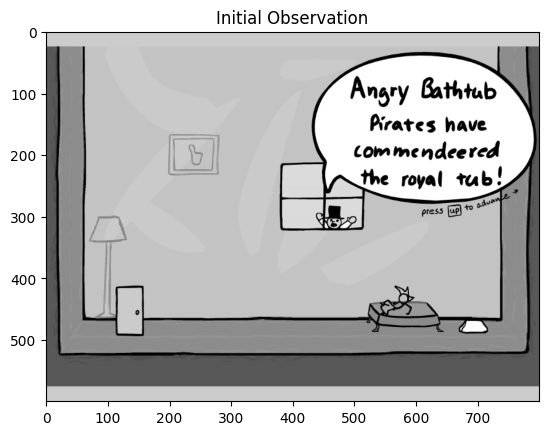

Cleaning up resources...
All processes terminated successfully.


In [5]:
def main():
    """
    Main function to set up the environment, enter the tutorial level, and capture an observation.
    """
    try:
        # Step 1: Ensure the port is free and start the Ruffle server
        print("Cleaning up the port and starting Ruffle server...")
        launch_ruffle.kill_port(PORT)  # Ensure the port is available
        server_process = start_ruffle_host()

        # Step 2: Start Safari WebDriver
        print("Starting Safari WebDriver and navigating to game URL...")
        safari_process, driver = start_safari_webdriver()

        # Step 3: Automate entering the tutorial level
        print("Automating game entry to reach the tutorial level...")
        safari_window = enter_game.get_most_recent_window_by_owner("Safari")
        if safari_window:
            enter_game.enter_game(safari_window)  # Navigate to the tutorial level
        else:
            print("No Safari window found. Exiting...")
            return

        # Step 4: Fetch canvas information and content offset
        print("Fetching game canvas size and position...")
        canvas_info = fetch_canvas_position_and_size(driver)
        if not canvas_info:
            print("Failed to fetch canvas info. Exiting...")
            return

        game_location = {
            'top': int(canvas_info['top']),
            'left': int(canvas_info['left']),
            'width': int(canvas_info['width']),
            'height': int(canvas_info['height']),
        }
        print("Game Location (Canvas Info):", game_location)

        # Fetch content offset to adjust the game location
        print("Fetching content offset for browser adjustments...")
        content_offset = fetch_content_offset(driver)
        adjusted_game_location = {
            'top': game_location['top'] + content_offset['yOffset'],
            'left': game_location['left'] + content_offset['xOffset'],
            'width': game_location['width'],
            'height': game_location['height'],
        }
        print("Adjusted Game Location:", adjusted_game_location)

        # Step 5: Initialize the FPAGame environment
        print("Initializing FPAGame environment...")
        env = FPAGame(adjusted_game_location)

        # Step 6: Capture an observation to verify setup
        print("Capturing initial observation from the game...")
        obs = env.get_observation()
        plt.imshow(obs[0], cmap='gray')  # Display the first channel as grayscale
        plt.title("Initial Observation")
        plt.show()

    except Exception as e:
        print("An error occurred:", e)
        traceback.print_exc()
    finally:
        # Cleanup processes
        print("Cleaning up resources...")
        server_process.terminate()
        safari_process.terminate()
        server_process.wait()
        safari_process.wait()
        print("All processes terminated successfully.")

if __name__ == "__main__":
    main()